<a href="https://colab.research.google.com/github/rkgupta7463/Openinapp-Company-Assignment/blob/main/Translation_of_English_to_Hindlish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###Import the requires libraries or modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,BatchNormalization,Dropout,Input
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
import re
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [3]:
# Path to the data txt file on disk.
data_path = "/content/drive/MyDrive/data.txt"

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")


for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [5]:
input_texts[:10]

['Wow!',
 'Duck!',
 'Duck!',
 'Help!',
 'Jump.',
 'Jump.',
 'Jump.',
 'Hello!',
 'Hello!',
 'Cheers!']

In [6]:
target_texts[:10]

['\tवाह!\n',
 '\tझुको!\n',
 '\tबतख़!\n',
 '\tबचाओ!\n',
 '\tउछलो.\n',
 '\tकूदो.\n',
 '\tछलांग.\n',
 '\tनमस्ते।\n',
 '\tनमस्कार।\n',
 '\tवाह-वाह!\n']

In [7]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [8]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 2979
Number of unique input tokens: 70
Number of unique output tokens: 90
Max sequence length for inputs: 107
Max sequence length for outputs: 123


In [9]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [10]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [12]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [13]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history=model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100
38/38 [==============================] - 70s 2s/step - loss: 1.2940 - accuracy: 0.7843 - val_loss: 2.1890 - val_accuracy: 0.6848
Epoch 2/100
38/38 [==============================] - 49s 1s/step - loss: 1.0109 - accuracy: 0.8071 - val_loss: 1.5558 - val_accuracy: 0.6869
Epoch 3/100
38/38 [==============================] - 50s 1s/step - loss: 0.9095 - accuracy: 0.8086 - val_loss: 1.8897 - val_accuracy: 0.6873
Epoch 4/100
38/38 [==============================] - 49s 1s/step - loss: 0.8405 - accuracy: 0.8090 - val_loss: 1.5475 - val_accuracy: 0.6873
Epoch 5/100
38/38 [==============================] - 49s 1s/step - loss: 0.8355 - accuracy: 0.8089 - val_loss: 1.3576 - val_accuracy: 0.6873
Epoch 6/100
38/38 [==============================] - 49s 1s/step - loss: 0.8017 - accuracy: 0.8082 - val_loss: 1.3622 - val_accuracy: 0.6873
Epoch 7/100
38/38 [==============================] - 49s 1s/step - loss: 0.7946 - accuracy: 0.8086 - val_loss: 1.3140 - val_accuracy: 0.6859
Epoch 8/100
3

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 70)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 90)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                334848    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

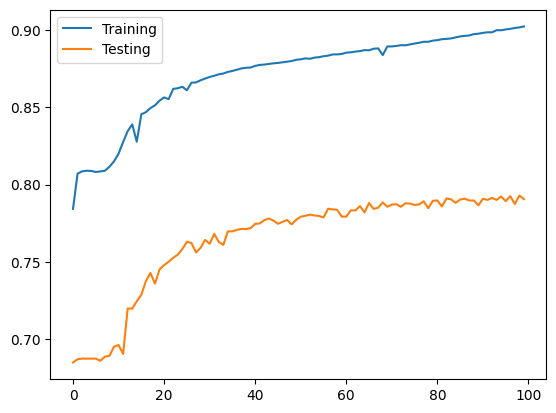

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label="Training")
plt.plot(history.history['val_accuracy'],label="Testing")
plt.legend()
plt.show()

In [16]:
# Save model
model.save("s2s")

In [17]:
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [19]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


1/1 [==============================] - 0s 27ms/step
-
Input sentence: Wow!
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 25ms/step
-
Input sentence: Duck!
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 41ms/step
-
Input sentence: Duck!
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Help!
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 27ms/step
-
Input sentence: Jump.
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 38ms/step
-
Input sentence: Jump.
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 25ms/step
-
Input sentence: Jump.
Decoded sentence: मैं अपनी में को साथ नहीं का सकता हूँ।

1/1 [==============================] - 0s 29ms/step
-
Input sentence: 